In [1]:
import os
import re
import numpy as np
import scipy.io
import scipy.signal as signal
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# GPU 메모리 설정 코드 추가
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import os

# ADHD 및 Control 파일 디렉토리 설정
adhd_save_dir = r"C:\Users\dlwld\Downloads\ADHD_epochs"
control_save_dir = r"C:\Users\dlwld\Downloads\Control_epochs"

# 파일명에서 피험자 ID와 에포크 번호를 추출하는 함수 (언더바 앞은 모두 피험자 ID로 설정)
def extract_subject_epoch(file_name):
    # 파일명을 먼저 확장자를 제외한 부분으로 나눔
    base_name = os.path.splitext(file_name)[0]
    
    # 언더바('_')로 파일명을 나누어 피험자 ID와 에포크 번호를 추출
    if '_' in base_name:
        parts = base_name.split('_')
        subject_id = parts[0]  # 언더바 앞의 부분이 피험자 ID
        epoch_num = parts[1][1:]  # 'e' 다음의 숫자가 에포크 번호
        return subject_id, epoch_num
    return None, None

# ADHD와 Control 디렉토리에서 파일 읽기
adhd_files = os.listdir(adhd_save_dir)
control_files = os.listdir(control_save_dir)

adhd_subjects = {}
control_subjects = {}

# ADHD 파일들의 피험자 ID별로 그룹화
for file in adhd_files:
    subject_id, epoch_num = extract_subject_epoch(file)
    if subject_id:
        if subject_id not in adhd_subjects:
            adhd_subjects[subject_id] = []
        adhd_subjects[subject_id].append(os.path.join(adhd_save_dir, file))

# Control 파일들의 피험자 ID별로 그룹화
for file in control_files:
    subject_id, epoch_num = extract_subject_epoch(file)
    if subject_id:
        if subject_id not in control_subjects:
            control_subjects[subject_id] = []
        control_subjects[subject_id].append(os.path.join(control_save_dir, file))

print(f"ADHD subjects: {adhd_subjects.keys()}")
print(f"Control subjects: {control_subjects.keys()}")


ADHD subjects: dict_keys(['v10p', 'v12p', 'v14p', 'v15p', 'v173', 'v177', 'v179', 'v181', 'v183', 'v18p', 'v190', 'v196', 'v198', 'v19p', 'v1p', 'v200', 'v204', 'v206', 'v209', 'v20p', 'v213', 'v215', 'v219', 'v21p', 'v227', 'v22p', 'v231', 'v234', 'v236', 'v238', 'v244', 'v246', 'v24p', 'v250', 'v254', 'v25p', 'v263', 'v265', 'v270', 'v274', 'v279', 'v27p', 'v284', 'v286', 'v288', 'v28p', 'v29p', 'v30p', 'v31p', 'v32p', 'v33p', 'v34p', 'v35p', 'v36p', 'v37p', 'v38p', 'v39p', 'v3p', 'v40p', 'v6p', 'v8p'])
Control subjects: dict_keys(['v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v120', 'v121', 'v123', 'v125', 'v127', 'v129', 'v131', 'v133', 'v134', 'v138', 'v140', 'v143', 'v147', 'v149', 'v151', 'v297', 'v298', 'v299', 'v300', 'v302', 'v303', 'v304', 'v305', 'v306', 'v307', 'v308', 'v309', 'v310', 'v41p', 'v42p', 'v43p', 'v44p', 'v45p', 'v46p', 'v47p', 'v48p', 'v49p', 'v50p', 'v51p', 'v52p', 'v53p', 'v54p', 'v55p', 'v56p', 'v57p', 'v58

In [4]:
def create_cnn_model(input_shape):
    model = models.Sequential()

    # 첫 번째 Residual Block
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='batch_norm1'))
    model.add(layers.ReLU(name='relu1'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpool1'))
    model.add(layers.Dropout(0.3, name='dropout1'))

    # 두 번째 Residual Block
    model.add(layers.Conv2D(128, (3, 3), padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='batch_norm2'))
    model.add(layers.ReLU(name='relu2'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpool2'))
    model.add(layers.Dropout(0.4, name='dropout2'))

    # 세 번째 Residual Block
    model.add(layers.Conv2D(256, (3, 3), padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='batch_norm3'))
    model.add(layers.ReLU(name='relu3'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpool3'))
    model.add(layers.Dropout(0.5, name='dropout3'))

    # 네 번째 Residual Block
    model.add(layers.Conv2D(512, (3, 3), padding='same', name='conv4'))
    model.add(layers.BatchNormalization(name='batch_norm4'))
    model.add(layers.ReLU(name='relu4'))
    model.add(layers.MaxPooling2D((2, 2), name='maxpool4'))
    model.add(layers.Dropout(0.5, name='dropout4'))

    # Fully Connected Layer
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='fc1'))
    model.add(layers.Dropout(0.5, name='dropout5'))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid', name='output'))

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


# 학습률 스케줄러 (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Early Stopping (과적합 방지)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Checkpoint (최적의 가중치 저장)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


In [5]:
# ADHD와 Control 피험자 분리
adhd_subjects_list = list(adhd_subjects.keys())
control_subjects_list = list(control_subjects.keys())

# ADHD는 1, Control은 0으로 라벨 설정
all_subjects = adhd_subjects_list + control_subjects_list
all_labels = [1] * len(adhd_subjects_list) + [0] * len(control_subjects_list)

k = 10  # 10개의 fold로 설정

# 교차검증을 위한 StratifiedKFold 생성 (ADHD/Control 비율 유지)
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


In [15]:
def plot_training_history(history):
    # 훈련 및 검증 손실 시각화
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_tsne(model, data, labels):
    # 모델의 중간 레이어에서 출력된 임베딩을 얻기 위해 flatten 레이어 전까지 모델을 자름
    layer_outputs = models.Model(inputs=model.input, outputs=model.get_layer('flatten').output)
    
    # 학습된 모델을 통해 데이터 임베딩 추출
    embeddings = layer_outputs.predict(data)
    
    # t-SNE 적용 (n_components=2로 2차원 공간에 시각화)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(embeddings)

    # ADHD와 Control 데이터 구분하여 시각화
    adhd_idx = (labels == 1)
    control_idx = (labels == 0)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[adhd_idx, 0], reduced_data[adhd_idx, 1], color='red', label='ADHD', alpha=0.5)
    plt.scatter(reduced_data[control_idx, 0], reduced_data[control_idx, 1], color='blue', label='Control', alpha=0.5)
    
    # x축과 y축 레이블 추가
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    plt.title('t-SNE visualization of data embeddings')
    plt.legend()
    plt.show()


In [7]:
# 샘플링 주파수 설정 (128Hz)
fs = 128

# 데이터를 불러오고 각 채널별로 PSD를 계산하는 함수
def load_data_with_psd(file_paths):
    data = []
    for file_path in file_paths:
        mat = scipy.io.loadmat(file_path)
        
        # 파일명에서 확장자를 제외한 기본 파일명 추출
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        
        # 기본 파일명을 그대로 키로 사용하여 데이터 로드
        if base_name in mat:
            raw_data = mat[base_name]
            
            num_channels = raw_data.shape[1]  # 19개 채널 (열 개수)
            psd_data = []
            
            # 각 채널별로 PSD 계산
            for channel in range(num_channels):
                channel_data = raw_data[:, channel]  # 각 채널 데이터 (2560 샘플)
                freqs, psd = signal.welch(channel_data, fs=fs, nperseg=128)  # nperseg을 샘플 길이에 맞게 설정
                psd_data.append(psd)
            
            psd_data = np.array(psd_data)
            
            # psd 데이터를 CNN이 처리할 수 있는 형태로 변환 (예: 64x65 크기로 재구성)
            if psd_data.shape[1] >= 64:  # 주파수 대역이 64 이상일 때만
                psd_reshaped = psd_data[:, :64].reshape(19, 64, 1)  # 채널 수를 유지한 채 19x64x1 크기로 변환
                data.append(psd_reshaped)
            else:
                raise ValueError(f"PSD data is too small for {base_name}. Expected at least 64 frequency bins.")
        else:
            raise KeyError(f"'{base_name}' key not found in {file_path}")
    
    return np.array(data)

In [8]:
# 평가 지표 저장 리스트
train_accuracy_list = []
accuracy_list = []
precision_adhd_list = []
precision_control_list = []
recall_adhd_list = []
recall_control_list = []
f1_adhd_list = []
f1_control_list = []
auc_list = []

In [9]:
# 교차 검증을 위한 fold 나누기 및 학습
input_shape = (19, 64, 1)  # 19x64 크기로 CNN에 입력

# Stratified KFold 사용하여 ADHD와 Control 비율 유지
for fold, (train_index, test_index) in enumerate(skf.split(all_subjects, all_labels)):
    # 각 fold마다 새로운 CNN 모델을 생성
    cnn_model = create_cnn_model(input_shape)  # 새로운 CNN 모델 생성

    train_subjects = [all_subjects[i] for i in train_index]
    test_subjects = [all_subjects[i] for i in test_index]

    # Train과 Test 데이터 나누기
    train_data, train_labels = [], []
    test_data, test_labels = [], []

    print(f"Fold {fold+1}:")
    
    for subject in train_subjects:
        if subject in adhd_subjects:
            train_data.extend(load_data_with_psd(adhd_subjects[subject]))
            train_labels.extend([1] * len(adhd_subjects[subject]))  # ADHD는 1로 라벨링
        elif subject in control_subjects:
            train_data.extend(load_data_with_psd(control_subjects[subject]))
            train_labels.extend([0] * len(control_subjects[subject]))  # Control은 0으로 라벨링

    for subject in test_subjects:
        if subject in adhd_subjects:
            test_data.extend(load_data_with_psd(adhd_subjects[subject]))
            test_labels.extend([1] * len(adhd_subjects[subject]))
        elif subject in control_subjects:
            test_data.extend(load_data_with_psd(control_subjects[subject]))
            test_labels.extend([0] * len(control_subjects[subject]))

    # NumPy 배열로 변환
    train_data = np.array(train_data).reshape(-1, 19, 64, 1)  # 19x64의 이미지 크기로 재구성
    test_data = np.array(test_data).reshape(-1, 19, 64, 1)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # 모델 학습
    history = cnn_model.fit(train_data, train_labels, epochs=100, validation_data=(test_data, test_labels), verbose=0)

    # 모델 평가
    train_metrics = cnn_model.evaluate(train_data, train_labels, verbose=1)
    test_metrics = cnn_model.evaluate(test_data, test_labels, verbose=1)

    # 평가 결과 추출 (train_loss, train_acc, test_loss, test_acc)
    train_loss = train_metrics[0]
    train_acc = train_metrics[1]
    test_loss = test_metrics[0]
    test_acc = test_metrics[1]

    # 예측 결과 가져오기
    y_pred = cnn_model.predict(test_data)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # 0.5 이상은 1로 예측

    # Confusion Matrix 기반의 Precision, Recall, F1-Score 계산
    test_precision_adhd = precision_score(test_labels, y_pred_classes, pos_label=1)
    test_precision_control = precision_score(test_labels, y_pred_classes, pos_label=0)
    test_recall_adhd = recall_score(test_labels, y_pred_classes, pos_label=1)
    test_recall_control = recall_score(test_labels, y_pred_classes, pos_label=0)
    test_f1_adhd = f1_score(test_labels, y_pred_classes, pos_label=1)
    test_f1_control = f1_score(test_labels, y_pred_classes, pos_label=0)

    # AUC 계산
    test_auc = roc_auc_score(test_labels, y_pred)

    # 리스트에 평가 지표 저장
    train_accuracy_list.append(train_acc)
    accuracy_list.append(test_acc)
    precision_adhd_list.append(test_precision_adhd)
    precision_control_list.append(test_precision_control)
    recall_adhd_list.append(test_recall_adhd)
    recall_control_list.append(test_recall_control)
    f1_adhd_list.append(test_f1_adhd)
    f1_control_list.append(test_f1_control)
    auc_list.append(test_auc)

    # Fold 결과 출력
    print(f"Fold {fold+1} Test Accuracy: {test_acc}")
    print(f"Fold {fold+1} Test Precision (ADHD): {test_precision_adhd}, Control: {test_precision_control}")
    print(f"Fold {fold+1} Test Recall (ADHD): {test_recall_adhd}, Control: {test_recall_control}")
    print(f"Fold {fold+1} Test F1-Score (ADHD): {test_f1_adhd}, Control: {test_f1_control}")
    print(f"Fold {fold+1} Test AUC: {test_auc}")


Fold 1:
3/3 [==============================] - 0s 2ms/step
Fold 1 Test Accuracy: 0.8765432238578796
Fold 1 Test Precision (ADHD): 0.8867924528301887, Control: 0.8571428571428571
Fold 1 Test Recall (ADHD): 0.9215686274509803, Control: 0.8
Fold 1 Test F1-Score (ADHD): 0.9038461538461539, Control: 0.8275862068965517
Fold 1 Test AUC: 0.8986928104575163
Fold 2:
3/3 [==============================] - 0s 2ms/step
Fold 2 Test Accuracy: 0.695652186870575
Fold 2 Test Precision (ADHD): 0.7209302325581395, Control: 0.6538461538461539
Fold 2 Test Recall (ADHD): 0.775, Control: 0.5862068965517241
Fold 2 Test F1-Score (ADHD): 0.7469879518072289, Control: 0.6181818181818182
Fold 2 Test AUC: 0.7103448275862069
Fold 3:
3/3 [==============================] - 0s 1ms/step
Fold 3 Test Accuracy: 0.8588235378265381
Fold 3 Test Precision (ADHD): 0.8, Control: 0.9666666666666667
Fold 3 Test Recall (ADHD): 0.9777777777777777, Control: 0.725
Fold 3 Test F1-Score (ADHD): 0.88, Control: 0.8285714285714286
Fold 3 Te

In [10]:
# 교차 검증 후 평균 및 표준편차 계산
def calculate_mean_std(metric_list):
    return np.mean(metric_list), np.std(metric_list)

# 각 지표에 대한 평균 및 표준편차 계산 및 출력
train_acc_mean, train_acc_std = calculate_mean_std(train_accuracy_list)
test_acc_mean, test_acc_std = calculate_mean_std(accuracy_list)
precision_adhd_mean, precision_adhd_std = calculate_mean_std(precision_adhd_list)
precision_control_mean, precision_control_std = calculate_mean_std(precision_control_list)
recall_adhd_mean, recall_adhd_std = calculate_mean_std(recall_adhd_list)
recall_control_mean, recall_control_std = calculate_mean_std(recall_control_list)
f1_adhd_mean, f1_adhd_std = calculate_mean_std(f1_adhd_list)
f1_control_mean, f1_control_std = calculate_mean_std(f1_control_list)
auc_mean, auc_std = calculate_mean_std(auc_list)

print("\n--- 교차 검증 결과 ---")
print(f"Train Accuracy: {train_acc_mean:.4f} ± {train_acc_std:.4f}")
print(f"Test Accuracy: {test_acc_mean:.4f} ± {test_acc_std:.4f}")
print(f"Precision (ADHD): {precision_adhd_mean:.4f} ± {precision_adhd_std:.4f}, Control: {precision_control_mean:.4f} ± {precision_control_std:.4f}")
print(f"Recall (ADHD): {recall_adhd_mean:.4f} ± {recall_adhd_std:.4f}, Control: {recall_control_mean:.4f} ± {recall_control_std:.4f}")
print(f"F1-Score (ADHD): {f1_adhd_mean:.4f} ± {f1_adhd_std:.4f}, Control: {f1_control_mean:.4f} ± {f1_control_std:.4f}")
print(f"AUC: {auc_mean:.4f} ± {auc_std:.4f}")


--- 교차 검증 결과 ---
Train Accuracy: 0.9912 ± 0.0033
Test Accuracy: 0.7823 ± 0.1233
Precision (ADHD): 0.7932 ± 0.1075, Control: 0.7763 ± 0.1582
Recall (ADHD): 0.8456 ± 0.1352, Control: 0.6897 ± 0.1898
F1-Score (ADHD): 0.8142 ± 0.1073, Control: 0.7220 ± 0.1651
AUC: 0.8448 ± 0.0977


22/22 [==============================] - 0s 11ms/step


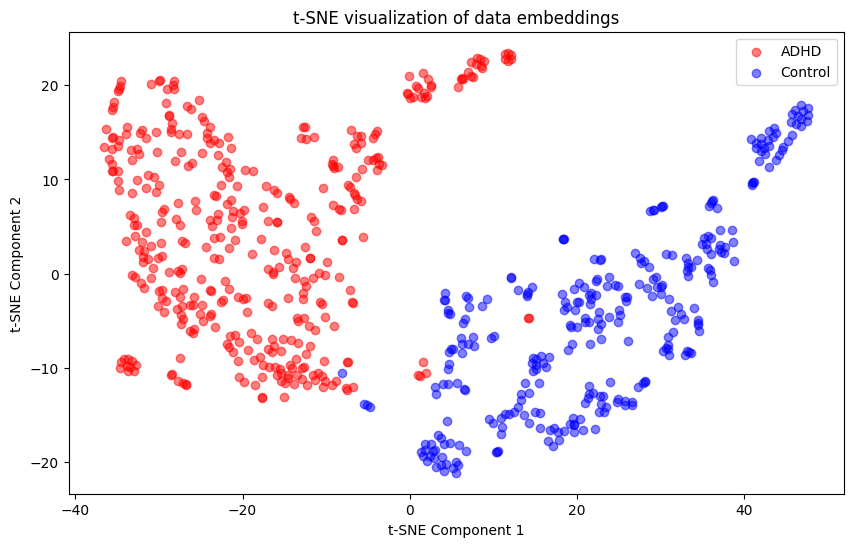

In [16]:
# Train 데이터에 대해 t-SNE 시각화 실행
plot_tsne(cnn_model, train_data, train_labels)


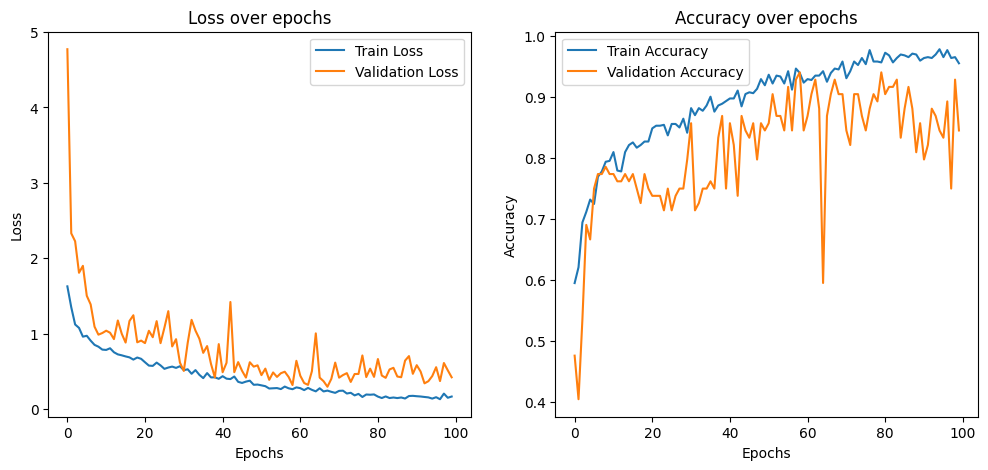

In [13]:
# 학습 결과 시각화
plot_training_history(history)
